In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import requests
import pickle
import re
from bs4 import BeautifulSoup
from sys import stdout

# Affiliations analysis

**In this notebook, we are only interested in the links created between characters that have the same affiliations. We will build an adjacency matrix based on that.**

# Part 1: Marvel dataset

In [2]:
with open('data/clean_marvel.txt', 'rb') as f:
    aff_marvel = pickle.load(f)

aff_marvel.drop(columns=['Relatives', 'Real Name', 'Current Alias', 'Subcomic URL', \
                         'Last appearance'], inplace=True)

aff_marvel

,URL,Affiliation,First appearance
0,/wiki/Aaron_Fox_(Earth-616),[],1975
1,/wiki/Acrobat_(1940s)_(Earth-616),[],1947
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),[],2017
3,/wiki/Ace_Maxwell_(Earth-616),[],1946
4,/wiki/Abigail_Boylen_(Earth-616),"[/wiki/Champions_(Earth-616), /wiki/Undergroun...",2007
...,...,...,...
26877,/wiki/Zzzyclone_(Warp_World)_(Earth-616),[],2019
26878,/wiki/Zuhn_(Earth-616),[],2000
26879,/wiki/Zxaxz_(Earth-616),[],1988
26880,/wiki/Zuwena_(Earth-616),[/wiki/Elephant%27s_Trunk_(Earth-616)],2018


**We split the list in the column `Affiliation`, each URL that is in it will be in a different row, with the corresponding character.**

In [3]:
s = aff_marvel.apply(lambda x: pd.Series(x['Affiliation']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Affiliation'

aff_marvel = aff_marvel.drop('Affiliation', axis=1).join(s)
aff_marvel['Affiliation'] = pd.Series(aff_marvel['Affiliation'], dtype= 'b')
aff_marvel

,URL,First appearance,Affiliation
0,/wiki/Aaron_Fox_(Earth-616),1975,
1,/wiki/Acrobat_(1940s)_(Earth-616),1947,
2,/wiki/Abigail_Mercury_(Clone)_(Earth-616),2017,
3,/wiki/Ace_Maxwell_(Earth-616),1946,
4,/wiki/Abigail_Boylen_(Earth-616),2007,/wiki/Champions_(Earth-616)
...,...,...,...
26877,/wiki/Zzzyclone_(Warp_World)_(Earth-616),2019,
26878,/wiki/Zuhn_(Earth-616),2000,
26879,/wiki/Zxaxz_(Earth-616),1988,
26880,/wiki/Zuwena_(Earth-616),2018,/wiki/Elephant%27s_Trunk_(Earth-616)


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [4]:
urls = aff_marvel['URL'].unique()
adj_aff_marvel = pd.DataFrame(0, index=urls, columns=urls)

**We fill the diagonal of the adjacency matrix. The displayed value corresponds to the total number of affiliations the character has.**

In [5]:
for url in aff_marvel['URL'].value_counts().index:
    if aff_marvel[aff_marvel['URL'] == url]['Affiliation'].sum() is not '' \
    and aff_marvel[aff_marvel['URL'] == url]['Affiliation'].sum() is not ' ':
        adj_aff_marvel[url][url] += aff_marvel['URL'].value_counts()[url]

**For a given affiliation, we see all the corresponding characters. Then we do all the possible combinations between them to fill the adjacency matrix. The more a character (C1) has common affiliations with another (C2), the higher will be the cell adjacency[C1][C2] (and adjacency[C2][C1]).**

In [6]:
i = 0
tot_aff = aff_marvel['Affiliation'].unique().size

for a in aff_marvel['Affiliation'].unique():
    if a is not '':
        # Loading bar
        i += 1
        printed= i/tot_aff*100
        stdout.write("\r%f %%" % printed)
        stdout.flush()

        L = []
        L = ([a,aff_marvel[aff_marvel['Affiliation']==a]['URL'].values.tolist()])
        # All possible combinations
        for comb in list(itertools.combinations(L[1], 2)):
            adj_aff_marvel[comb[0]][comb[1]] += 1
            adj_aff_marvel[comb[1]][comb[0]] += 1

99.979650 %

In [7]:
adj_aff_marvel

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Abigail_Mercury_(Clone)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abigail_Boylen_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),...,/wiki/Zuras_(Earth-616),/wiki/Zreate%27th_(Earth-616),/wiki/Zyziwc_Tiel_(Earth-616),/wiki/Zuzha_Yu_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zzzyclone_(Warp_World)_(Earth-616),/wiki/Zuhn_(Earth-616),/wiki/Zxaxz_(Earth-616),/wiki/Zuwena_(Earth-616),/wiki/Zurvan_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Mercury_(Clone)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Boylen_(Earth-616),0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zzzyclone_(Warp_World)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zuhn_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zxaxz_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zuwena_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
pickle.dump(adj_aff_marvel, open("data/adj_aff_marvel.txt", 'wb'), protocol=4)

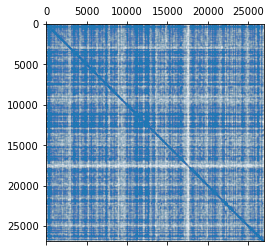

In [9]:
plt.spy(adj_aff_marvel,markersize=0.01)

In [28]:
#1950, 1990, Now
aff_marvel.reset_index(drop=True, inplace =True)
list_index_1950 = aff_marvel.loc[aff_marvel["First appearance"] < 1950, "URL"].unique().tolist()
list_index_1990 = aff_marvel.loc[aff_marvel["First appearance"] < 1990, "URL"].unique().tolist()

In [29]:
adj_aff_marvel_50 = adj_aff_marvel[adj_aff_marvel.index.isin(list_index_1950)]
adj_aff_marvel_50 = adj_aff_marvel_50.reindex(columns = list_index_1950, fill_value=0)
adj_aff_marvel_50

,/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/A.J._Raffles_(Earth-616),/wiki/Abraham_Erskine_(Earth-616),/wiki/Abra_and_Cadabra_(Earth-616),/wiki/Abner_Perkins_(Earth-616),/wiki/Ace_Turmbull_(Earth-616),/wiki/Aarkus_(Earth-616),/wiki/Ab_Waltin_(Earth-616),/wiki/Able_Doone_(Earth-616),...,/wiki/Zombo_(Earth-616),/wiki/Zerhu_(Earth-616),/wiki/Zombie_Master_(Earth-616),/wiki/Zephyrus_Jones_(Earth-616),/wiki/Zeb_Sanders_(Earth-616),/wiki/Zeke_Mallon_(Earth-616),/wiki/Zandow_(Earth-616),/wiki/Zipper_(1940%27s_Criminal)_(Earth-616),/wiki/Zomber_(Earth-616),/wiki/Zuras_(Earth-616)
/wiki/Acrobat_(1940s)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/A.J._Raffles_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abraham_Erskine_(Earth-616),0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abra_and_Cadabra_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zeke_Mallon_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zandow_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
/wiki/Zipper_(1940%27s_Criminal)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
/wiki/Zomber_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pickle.dump(adj_aff_marvel_50, open("data/adj_aff_marvel_50.txt", 'wb'), protocol=4)

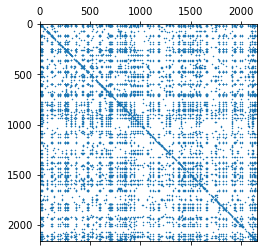

In [35]:
plt.spy(adj_aff_marvel_50,markersize=0.5)

In [31]:
adj_aff_marvel_90 = adj_aff_marvel[adj_aff_marvel.index.isin(list_index_1990)]
adj_aff_marvel_90 = adj_aff_marvel_90.reindex(columns = list_index_1990, fill_value=0)
adj_aff_marvel_90

,/wiki/Aaron_Fox_(Earth-616),/wiki/Acrobat_(1940s)_(Earth-616),/wiki/Ace_Maxwell_(Earth-616),/wiki/Abarac_(Earth-616),/wiki/Abner_Perry_(Earth-616),/wiki/Abdul_Qamar_(Earth-616),/wiki/Aaron_Verne_(Earth-616),/wiki/Abner_Doolittle_(Earth-616),/wiki/Abdul_Hurani_(Earth-616),/wiki/A3_(Earth-616),...,/wiki/Zsaji_(Earth-616),/wiki/Zuko_(Earth-616),/wiki/Zyro_(Earth-616),/wiki/Zukala_(Earth-616),/wiki/Zzutak_(Earth-616),/wiki/Zzzax_(Earth-616),/wiki/Zota_of_Pergamum_(Earth-616),/wiki/Zuras_(Earth-616),/wiki/Zula_(Earth-616),/wiki/Zxaxz_(Earth-616)
/wiki/Aaron_Fox_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Acrobat_(1940s)_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Maxwell_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abarac_(Earth-616),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abner_Perry_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zzzax_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zota_of_Pergamum_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zuras_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
/wiki/Zula_(Earth-616),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,802,0


In [32]:
pickle.dump(adj_aff_marvel_90, open("data/adj_aff_marvel_90.txt", 'wb'), protocol=4)

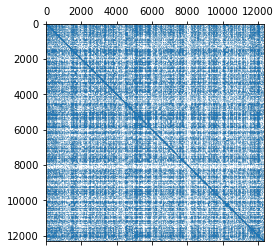

In [33]:
plt.spy(adj_aff_marvel_90,markersize=0.05)

# Part 2: DC dataset

In [10]:
with open('data/clean_dc.txt', 'rb') as f:
    aff_dc = pickle.load(f)

aff_dc.drop(columns=['Relatives', 'Real Name', 'Current Alias', 'Subcomic URL', \
                     'Last appearance'], inplace=True)

aff_dc

,URL,Affiliation,First appearance
0,/wiki/Aaron_Hayley_(New_Earth),[],1998.0
1,/wiki/Adam_Strange_(JSA:_The_Golden_Age),[],1994.0
2,/wiki/Alan_Barnes_(New_Earth),[],1994.0
3,/wiki/Alan_Scott_(Earth_2),"[/wiki/Wonders_of_the_World, /wiki/The_Green]",2012.0
4,/wiki/Abigail_Arcane_(New_Earth),[],1973.0
...,...,...,...
13184,/wiki/Zod_(Smallville),[],2013.0
13185,/wiki/Zazzala_(Prime_Earth),[],2019.0
13186,/wiki/Zedabon_Zarr_(Earth-One),[],1966.0
13187,/wiki/Zotan_(Earth-S),[],1953.0


**We split the list in the column `Affiliation`, each URL that is in it will be in a different row, with the corresponding character.**

In [11]:
s = aff_dc.apply(lambda x: pd.Series(x['Affiliation']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Affiliation'

aff_dc = aff_dc.drop('Affiliation', axis=1).join(s)
aff_dc['Affiliation'] = pd.Series(aff_dc['Affiliation'], dtype= 'b')
aff_dc

,URL,First appearance,Affiliation
0,/wiki/Aaron_Hayley_(New_Earth),1998.0,
1,/wiki/Adam_Strange_(JSA:_The_Golden_Age),1994.0,
2,/wiki/Alan_Barnes_(New_Earth),1994.0,
3,/wiki/Alan_Scott_(Earth_2),2012.0,/wiki/Wonders_of_the_World
3,/wiki/Alan_Scott_(Earth_2),2012.0,/wiki/The_Green
...,...,...,...
13184,/wiki/Zod_(Smallville),2013.0,
13185,/wiki/Zazzala_(Prime_Earth),2019.0,
13186,/wiki/Zedabon_Zarr_(Earth-One),1966.0,
13187,/wiki/Zotan_(Earth-S),1953.0,


**We create a list of unique urls, and use it as rows and columns of the adjacency matrix.**

In [12]:
urls = aff_dc['URL'].unique()
adj_aff_dc = pd.DataFrame(0, index=urls, columns=urls)

**We fill the diagonal of the adjacency matrix. The displayed value corresponds to the total number of affiliations the character has.**

In [13]:
for url in aff_dc['URL'].value_counts().index:
    if aff_dc[aff_dc['URL'] == url]['Affiliation'].sum() is not '' \
    and aff_dc[aff_dc['URL'] == url]['Affiliation'].sum() is not ' ':
        adj_aff_dc[url][url] += aff_dc['URL'].value_counts()[url]

**As for Marvel, we see the corresponding characters to one affiliation and we fill in the adjacency.**

In [14]:
i = 0
tot_aff = aff_dc['Affiliation'].unique().size

for a in aff_dc['Affiliation'].unique():
    if a is not '' and a is not ' ':
        # Loading bar
        i += 1
        printed= i/tot_aff*100
        stdout.write("\r%f %%" % printed)
        stdout.flush()

        L = []
        L = ([a,aff_dc[aff_dc['Affiliation']==a]['URL'].values.tolist()])
        # All possible combinations
        for comb in list(itertools.combinations(L[1], 2)):
            adj_aff_dc[comb[0]][comb[1]] += 1
            adj_aff_dc[comb[1]][comb[0]] += 1

99.954812 %

In [15]:
adj_aff_dc

,/wiki/Aaron_Hayley_(New_Earth),/wiki/Adam_Strange_(JSA:_The_Golden_Age),/wiki/Alan_Barnes_(New_Earth),/wiki/Alan_Scott_(Earth_2),/wiki/Abigail_Arcane_(New_Earth),/wiki/Abigail_Hunkel_(New_Earth),/wiki/Abra-Ka-Dabra_(Tiny_Titans),/wiki/Adam_Strange_(The_Brave_and_the_Bold),/wiki/Adam_Strange_II_(Earth-One),/wiki/Agrippe_(New_Earth),...,/wiki/Z%C3%BCM_(New_Earth),/wiki/Zobar_Zodiak_(New_Earth),/wiki/Zephyr_(New_Earth),/wiki/Zwerg_(New_Earth),/wiki/Zera_Oliet_(Pre-Zero_Hour),/wiki/Zod_(Smallville),/wiki/Zazzala_(Prime_Earth),/wiki/Zedabon_Zarr_(Earth-One),/wiki/Zotan_(Earth-S),/wiki/Zora_Vi-Lar_(Earth-One)
/wiki/Aaron_Hayley_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Adam_Strange_(JSA:_The_Golden_Age),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Barnes_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Scott_(Earth_2),0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Arcane_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zod_(Smallville),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zazzala_(Prime_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zedabon_Zarr_(Earth-One),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zotan_(Earth-S),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
pickle.dump(adj_aff_dc, open("data/adj_aff_dc.txt", 'wb'), protocol=4)

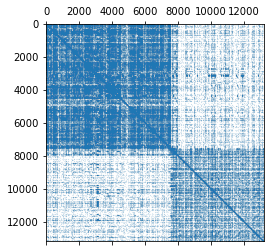

In [17]:
plt.spy(adj_aff_dc,markersize=0.03)

In [19]:
#1950, 1990, Now
aff_dc.reset_index(drop=True, inplace =True)
list_index_1950 = aff_dc.loc[aff_dc["First appearance"] < 1950, "URL"].unique().tolist()
list_index_1990 = aff_dc.loc[aff_dc["First appearance"] < 1990, "URL"].unique().tolist()

In [20]:
adj_aff_dc_50 = adj_aff_dc[adj_aff_dc.index.isin(list_index_1950)]
adj_aff_dc_50 = adj_aff_dc_50.reindex(columns = list_index_1950, fill_value=0)
adj_aff_dc_50

,/wiki/Abigail_Hunkel_(New_Earth),/wiki/Alan_Armstrong_(Earth-S),/wiki/Abraham_Davis_(New_Earth),/wiki/Achilles_(Earth-S),/wiki/Abraham_Lincoln_(New_Earth),/wiki/Ace_Egan_(Quality_Universe),/wiki/Achilles_(New_Earth),/wiki/Alan_Ladd_(Earth-One),/wiki/Abdul_Ibn_Bey_(Quality_Universe),/wiki/Abraham_Lincoln_(Earth-S),...,/wiki/William_Deegan_(Earth-Two),/wiki/Xaxol_(Quality_Universe),/wiki/William_Chantey_(Earth-Two),/wiki/Woodson_Hex_(New_Earth),/wiki/Wotan_(Quality_Universe),/wiki/Yellow_Wasp_(New_Earth),/wiki/Wind_Master_(Earth-Two),/wiki/Winslow_Schott_(Earth-Two),/wiki/Zool_(Earth-Two),/wiki/Zara_(Earth-Two)
/wiki/Abigail_Hunkel_(New_Earth),2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Armstrong_(Earth-S),0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abraham_Davis_(New_Earth),0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Achilles_(Earth-S),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abraham_Lincoln_(New_Earth),0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Yellow_Wasp_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Wind_Master_(Earth-Two),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Winslow_Schott_(Earth-Two),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zool_(Earth-Two),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
pickle.dump(adj_aff_dc_50, open("data/adj_aff_dc_50.txt", 'wb'), protocol=4)

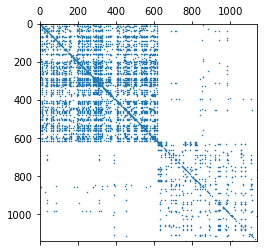

In [23]:
plt.spy(adj_aff_dc_50,markersize=0.5)

In [24]:
adj_aff_dc_90 = adj_aff_dc[adj_aff_dc.index.isin(list_index_1990)]
adj_aff_dc_90 = adj_aff_dc_90.reindex(columns = list_index_1990, fill_value=0)
adj_aff_dc_90

,/wiki/Abigail_Arcane_(New_Earth),/wiki/Abigail_Hunkel_(New_Earth),/wiki/Adam_Strange_II_(Earth-One),/wiki/Alan_Armstrong_(Earth-S),/wiki/Ace_Arn_(New_Earth),/wiki/Abraham_Davis_(New_Earth),/wiki/Achilles_(Earth-S),/wiki/Adam_Blake_(New_Earth),/wiki/500-ZQ_(New_Earth),/wiki/Abraham_Lincoln_(New_Earth),...,/wiki/Zyklon_(New_Earth),/wiki/Zodiac_Master_(Earth-One),/wiki/Zuggernaut_(New_Earth),/wiki/Zebra-Man_II_(New_Earth),/wiki/Zobar_Zodiak_(New_Earth),/wiki/Zwerg_(New_Earth),/wiki/Zera_Oliet_(Pre-Zero_Hour),/wiki/Zedabon_Zarr_(Earth-One),/wiki/Zotan_(Earth-S),/wiki/Zora_Vi-Lar_(Earth-One)
/wiki/Abigail_Arcane_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Abigail_Hunkel_(New_Earth),0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Adam_Strange_II_(Earth-One),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Alan_Armstrong_(Earth-S),0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Ace_Arn_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/Zwerg_(New_Earth),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/Zera_Oliet_(Pre-Zero_Hour),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
/wiki/Zedabon_Zarr_(Earth-One),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Zotan_(Earth-S),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
pickle.dump(adj_aff_dc_90, open("data/adj_aff_dc_90.txt", 'wb'), protocol=4)

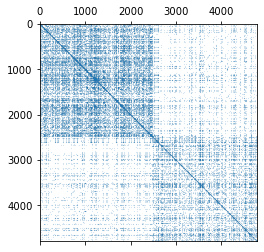

In [27]:
plt.spy(adj_aff_dc_90,markersize=0.05)